In [241]:
import torch
from torch import nn
import torchvision
import requests
import zipfile
from pathlib import Path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchinfo
import os
import random
from PIL import Image
from typing import Tuple, Dict, List
import tqdm.auto import tqdm

SyntaxError: invalid syntax (3613932177.py, line 14)

In [ ]:
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} already exists')
else:
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print('Downloading data...')
        f.write(request.content)

    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_file:
        zip_file.extractall(image_path)

# 1. Data Preparation
Data preparation is paramount. Before building a model, become one with the data. **Ask yourself: What am I trying to do here?**

The goal is to **take data storage structure and convert it into a dataset usable for our model-building purposes**

In [242]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [243]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [244]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

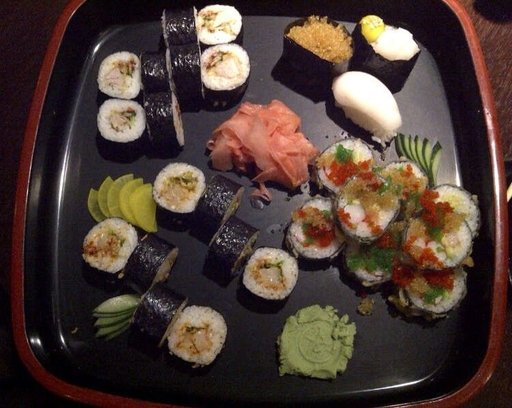

In [245]:
random.seed(178)
image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img

# 2. Data Transformation
1. Turn data into tensors, i.e., numerical representation
2. Turn the numerical representation into a ```torch.utils.data.Dataset``` and subsequently, into a ```torch.utils.data.DataLoader```

In [246]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(64, 64)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])

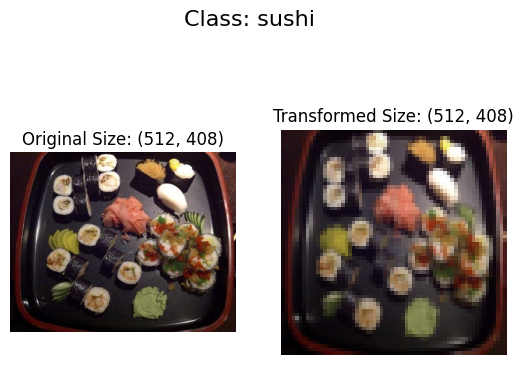

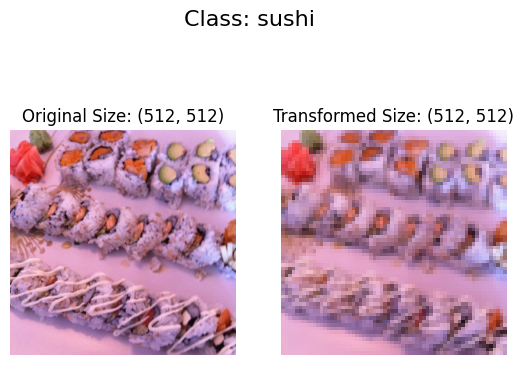

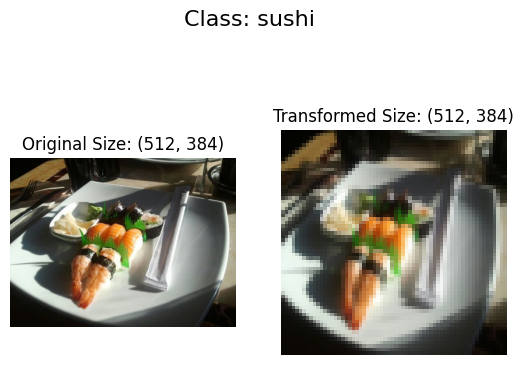

In [247]:
def plot_transformed_images(image_paths, transform, n=3, seed=178):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original Size: {f.size}')
            ax[0].axis('off')


            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Size: {f.size}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)


plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

# 3. Loading Image Data Using ```ImageFolder```

In [248]:
training_data = torchvision.datasets.ImageFolder(root=train_dir,
                                                 transform=data_transform,
                                                 target_transform=None)

test_data = torchvision.datasets.ImageFolder(root=test_dir,
                                             transform=data_transform)

print(f'Training data: {training_data},'
      f'Test data: {test_data}')

Training data: Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ),Test data: Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [249]:
class_names = training_data.classes
class_names

['pizza', 'steak', 'sushi']

In [250]:
class_dict = training_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [251]:
len(training_data), len(test_data)

(225, 75)

In [252]:
os.cpu_count()

8

In [253]:
training_dataloader = DataLoader(dataset=training_data,
                                 batch_size=1,
                                 num_workers=1,
                                 shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=True)

training_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x140b6998390>,
 <torch.utils.data.dataloader.DataLoader at 0x140b7052c50>)

# 4. Loading Image Data with Custom ```Dataset```

# 5. Data Augmentation
**Data Augmentation** is the process of altering the data in such a way that the **diversity** of the data is increased. This culminates in a model which is more capable of *generalization*.

In [254]:
training_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=31),
    torchvision.transforms.ToTensor(),
])

test_transformations = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])

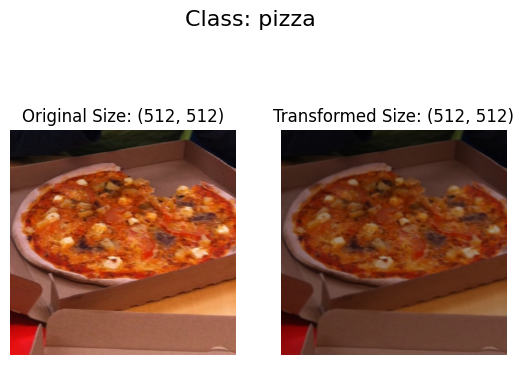

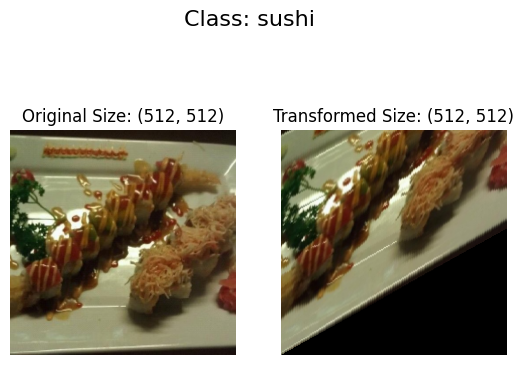

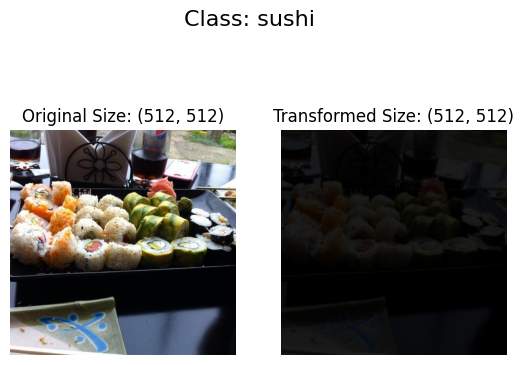

In [255]:
plot_transformed_images(image_path_list, training_transforms, seed=None)

# 6. Model 0: TinVGG without Data Augmentation

In [256]:
simple_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
])

In [257]:
training_data_simple = torchvision.datasets.ImageFolder(root=train_dir, transform=simple_transforms)

test_data_simple = torchvision.datasets.ImageFolder(root=test_dir, transform=simple_transforms)

In [258]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

training_dataloader_simple = DataLoader(training_data_simple,
                                        BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

training_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x140b723e890>,
 <torch.utils.data.dataloader.DataLoader at 0x140b7232e10>)

In [259]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

In [260]:
torch.manual_seed(178)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(training_data.classes))

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [261]:
torchinfo.summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [262]:
def training_phase(model: torch.nn.Module,
                   dataloader: torch.utils.data.DataLoader,
                   loss_func: torch.nn.Module,
                   optimizer: torch.optim.Optimizer):
    model.train()
    training_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)

        loss = loss_func(y_pred, y)
        training_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

    training_loss /= len(dataloader)

    return training_loss

In [263]:
def test_phase(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_func: torch.nn.Module):

    model.eval()
    test_loss = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            test_pred_logits = model(X)
            loss = loss_func(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_label = test_pred_logits.argmax(dim=1)


    test_loss /= len(dataloader)

    return test_loss

In [264]:
def train(model: torch.nn.Module,
          training_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_func: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int=10):
    results = {
        'training_loss': [],
        'test_loss': [],
    }

    for epoch in (range(epochs)):
        training_loss = training_phase(model,
                                       dataloader=training_dataloader,
                                       loss_func=loss_func,
                                       optimizer=optimizer)
        test_loss = test_phase(model,
                               dataloader=test_dataloader,
                               loss_func=loss_func)

        print(f'Epoch: {epoch},'
              f'training_loss: {training_loss:.4f},'
              f'test_loss: {test_loss:.4f}')

        results['training_loss'].append(training_loss)
        results['test_loss'].append(test_loss)

    return results

In [265]:
torch.manual_seed(178)
NUM_EPOCHS=10

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(training_data.classes))

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.1)

model_0_results = train(model_0,
                        training_dataloader_simple,
                        test_dataloader_simple,
                        loss_func,
                        optimizer,
                        epochs=NUM_EPOCHS)

model_0_results

Epoch: 0,training_loss: 21.4745,test_loss: 1.0954
Epoch: 1,training_loss: 1.0884,test_loss: 1.0802
Epoch: 2,training_loss: 2.2503,test_loss: 1.0844
Epoch: 3,training_loss: 1.1614,test_loss: 1.1037
Epoch: 4,training_loss: 1.0977,test_loss: 1.1015
Epoch: 5,training_loss: 1.1234,test_loss: 1.1401
Epoch: 6,training_loss: 1.1451,test_loss: 1.1468
Epoch: 7,training_loss: 1.0978,test_loss: 1.1205
Epoch: 8,training_loss: 1.1382,test_loss: 1.1272
Epoch: 9,training_loss: 1.0948,test_loss: 1.1160


{'training_loss': [21.47451238334179,
  1.0883755013346672,
  2.250349886715412,
  1.1613866537809372,
  1.0976648479700089,
  1.123441994190216,
  1.145062893629074,
  1.0978070497512817,
  1.1381748616695404,
  1.094766616821289],
 'test_loss': [1.0953832864761353,
  1.0802000363667805,
  1.0844128529230754,
  1.1036837895711262,
  1.1015249490737915,
  1.1400854587554932,
  1.1467749277750652,
  1.120464563369751,
  1.1271795431772869,
  1.115958333015442]}

In [266]:
def plot_loss_curve(results: Dict[str, List[float]]):
    loss = results['training_loss']
    test_loss = results['test_loss']

    epochs = range(len(results['training_loss']))

    plt.figure(figsize=(15, 7))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show();

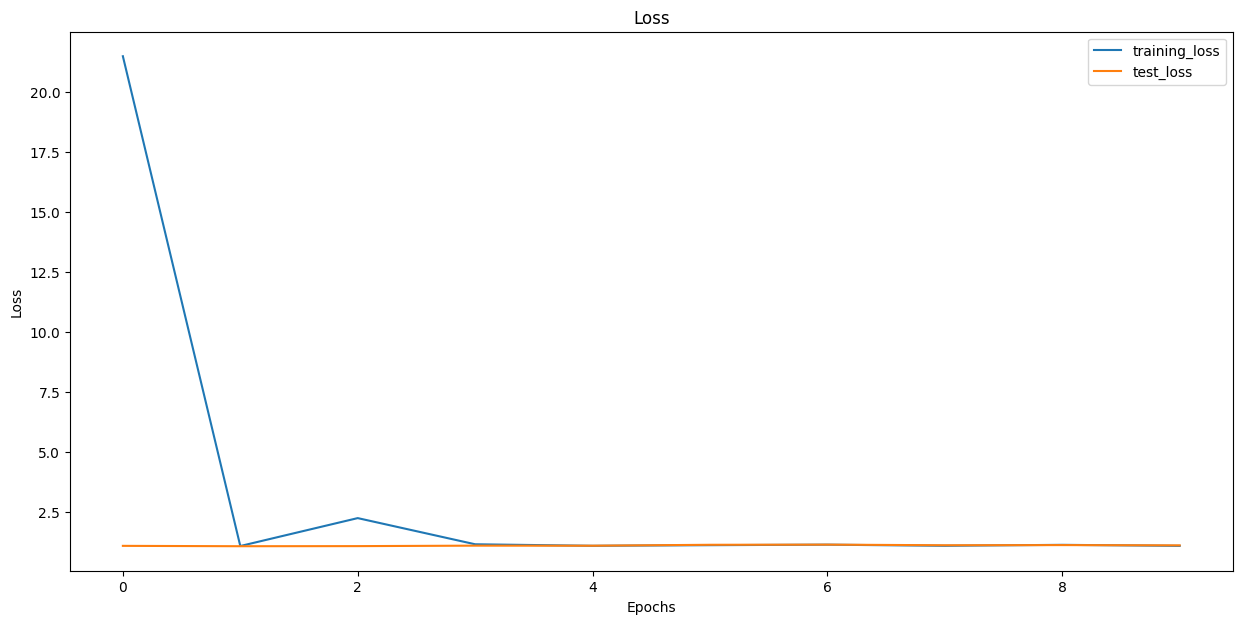

In [267]:
plot_loss_curve(model_0_results)

# 7. Model 1: TinVGG with Data Augmentation

In [268]:
training_transform_trivial_augment = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=31),
    torchvision.transforms.ToTensor()
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor()
])

In [269]:
training_data_augmented = torchvision.datasets.ImageFolder(train_dir, transform=training_transform_trivial_augment)
test_data_simple = torchvision.datasets.ImageFolder(test_dir, transform=test_transform)

training_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [270]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(218)
training_dataloader_augmented = DataLoader(training_data_augmented,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

training_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x140afc651d0>,
 <torch.utils.data.dataloader.DataLoader at 0x140b71f0350>)

In [272]:
torch.manual_seed(218)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(training_data_augmented.classes))

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [273]:
torch.manual_seed(218)
NUM_EPOCHS=10

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        training_dataloader=training_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_func=loss_func,
                        epochs=NUM_EPOCHS)

Epoch: 0,training_loss: 1.1000,test_loss: 1.0849
Epoch: 1,training_loss: 1.0775,test_loss: 1.1035
Epoch: 2,training_loss: 1.1065,test_loss: 1.1083
Epoch: 3,training_loss: 1.0713,test_loss: 1.1120
Epoch: 4,training_loss: 1.0897,test_loss: 1.0975
Epoch: 5,training_loss: 1.0526,test_loss: 1.0488
Epoch: 6,training_loss: 1.0235,test_loss: 1.0496
Epoch: 7,training_loss: 1.0321,test_loss: 1.0428
Epoch: 8,training_loss: 1.0399,test_loss: 1.0075
Epoch: 9,training_loss: 0.9619,test_loss: 0.9977


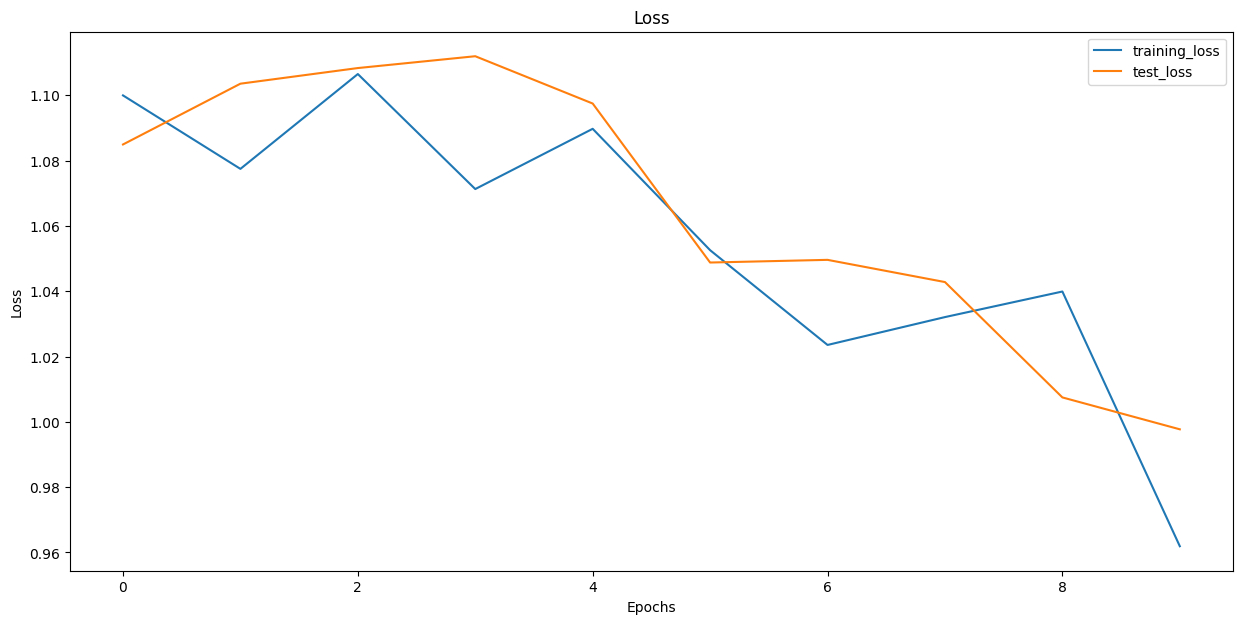

In [274]:
plot_loss_curve(model_1_results)

In [275]:
custom_image_path = data_path / '04_pizza-dad.jpeg'

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        f.write(request.content)

In [276]:
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f'Custom Image Tensor: {custom_image_uint8}')

Custom Image Tensor: tensor([[[154, 175, 181,  ...,  21,  18,  14],
         [146, 167, 180,  ...,  21,  18,  15],
         [124, 146, 171,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 189, 193,  ...,  22,  19,  15],
         [163, 181, 194,  ...,  22,  19,  16],
         [141, 163, 185,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 106, 104, 102],
         [ 47,  38,  24,  ..., 108, 105, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[117, 138, 145,  ...,  17,  14,  10],
         [109, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  54,  52,  50],
         [ 27,  18,   4,  ...,  50,  47,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)


In [278]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8)

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [279]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255

print(f'Custom image tensor: {custom_image}')

Custom image tensor: tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

In [280]:
custom_image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)

C:\Users\shabnam.zareshahraki\OneDrive - Consat\Skrivbordet\learning\code-practice\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [281]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [284]:
model_1.eval()
with torch.inference_mode():
    custom_image_transformed_batch = custom_image_transformed.unsqueeze(dim=0)

    custom_image_pred = model_1(custom_image_transformed_batch)

In [285]:
custom_image_probs = torch.softmax(custom_image_pred, dim=1)

custom_image_pred_label = torch.argmax(custom_image_probs, dim=1)

In [286]:
custom_image_pred_label

tensor([0])

In [287]:
class_names[custom_image_pred_label]

'pizza'

In [288]:
custom_image_probs

tensor([[0.4113, 0.3877, 0.2010]])